$\textbf{x}\in\Omega$

$$\frac{\partial u}{\partial t} = \nabla\cdot(\kappa\nabla u)$$

$$\int_\Omega\text{d}x~v\frac{\partial u}{\partial t} + \nabla v\cdot\kappa\nabla u - \int_{\partial\Omega}\text{d}s~v(\textbf{n}\cdot\kappa\nabla u)=0$$

$$\int_\Omega\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t} + \nabla v\cdot\kappa\nabla\mathcal{D}(u) - \int_{\partial\Omega}\text{d}s~v(\textbf{n}\cdot\kappa\nabla u)=0$$

$\textbf{x}\in\partial\Omega_D$ Dirichlet boundary condition

$$u = u_D$$

$\textbf{x}\in\partial\Omega_N=\partial\Omega/\partial\Omega_D$ Neumann boundary condition

$$\textbf{n}\cdot\kappa\nabla{u} = u_N$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import Form, dx, inner, grad, TestFunction

from lucifex.mesh import rectangle_mesh, interval_mesh, mesh_boundary
from lucifex.fdm import (
    DT, BE,
    FiniteDifference, FunctionSeries,
)
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import ibvp_solver, BoundaryConditions
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import cross_section


def diffusion(
    u: FunctionSeries,
    dt: Constant | float,
    k: Function | Constant | Expr,
    Dfdm: FiniteDifference,
    bcs: BoundaryConditions | None = None,
) -> list[Form]:
    v = TestFunction(u.function_space)
    Ft = v * DT(u, dt) * dx
    Fd = inner(grad(v), k * grad(Dfdm(u))) * dx
    forms = [Ft, Fd]
    if bcs is not None:
        ds, neumann_data = bcs.boundary_data(u.function_space, 'neumann')
        F_neumann = sum([-v * uN * ds(i) for i, uN in neumann_data])
        forms.append(F_neumann)
    return forms

### $d=1$

$$\Omega = [0, L_x]$$

$$\mathcal{D}=\text{BE}$$

$x=0$ and $x=L_x$ Dirichlet boundaries

$$u=0$$

In [2]:
Lx = 2.0
mesh = interval_mesh(Lx, 100)
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
    },
)

dt = Constant(mesh, 0.01, name='dt')
k = Constant(mesh, 1.0, name='k')

ics = lambda x: np.exp(-(x[0] - Lx/2)**2 / (0.01 * Lx))
bcs =  BoundaryConditions(
    ("dirichlet", boundary['left', 'right'], 0.0), 
)
u = FunctionSeries((mesh, 'P', 1), name='u', store=1)
u_solver = ibvp_solver(diffusion, ics, bcs)(u, dt, k, BE)

In [3]:
t = 0.0
t_stop = 10.0
n = 0
n_stop = 5

while n < n_stop and t < t_stop:
    u_solver.solve()
    u.forward(t)
    t += dt.value
    n += 1

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

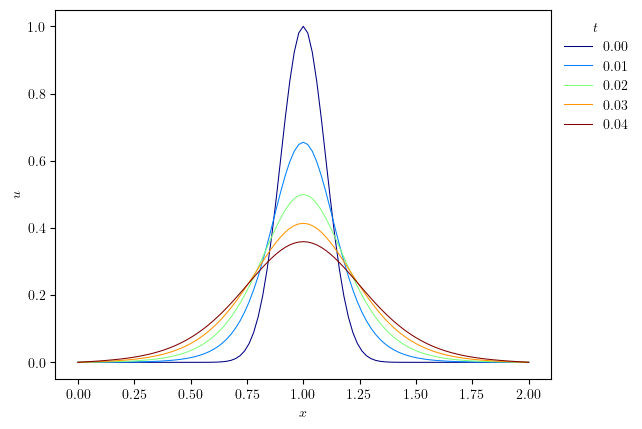

In [4]:
slc = slice(0, None)
legend_labels = [f'{t:.2f}' for t in u.time_series[slc]]
plot_line(u.series[slc], legend_labels, 't', cycler='jet', x_label='x', y_label=u.name)

### $d=2$

$$\Omega = [0, L_x] \times [0, L_y]$$

$$\mathcal{D}=\text{BE}$$

$\textbf{x} \in\{(x, y)~:~0\leq x\leq L_x,~y=0\}\cup\{(x, y)~:~0\leq x\leq L_x,~y=L_y\}=\partial\Omega_D$

$$u=0$$

$\textbf{x} \in\{(x, y)~:~x=0,~0\leq y\leq L_y\}\cup\{(x, y)~:~x=L_x,~0\leq y\leq L_y\}=\partial\Omega_N$

$$\textbf{n}\cdot\kappa\nabla u=0$$

In [ ]:
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 100, 100)
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

dt = Constant(mesh, 0.01, name='dt')
k = Constant(mesh, 0.1, name='k')

ics = lambda x: np.exp(-((x[0] - Lx/2)**2 + (x[1] - Ly/2)**2)/ (0.01 * Lx))
bcs_D = BoundaryConditions(
    ("dirichlet", boundary['lower', 'upper'], 0.0),  
)
bcs_N =  BoundaryConditions(
    ("neumann", boundary['left', 'right'], 0.0), 
)
u = FunctionSeries((mesh, 'P', 1), name='u', store=1)
u_solver = ibvp_solver(diffusion, ics, bcs_D)(u, dt, k, BE, bcs_N)

In [6]:
t = 0.0
t_stop = 10.0
n = 0
n_stop = 10

while n < n_stop and t < t_stop:
    u_solver.solve()
    u.forward(t)
    t += dt.value
    n += 1

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$y$', ylabel='$u(x=0.50)$'>)

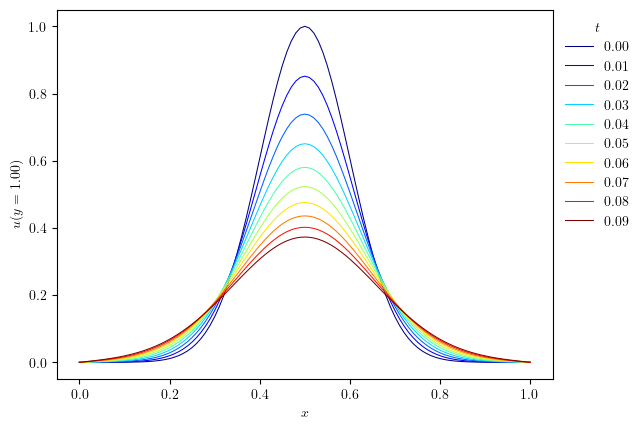

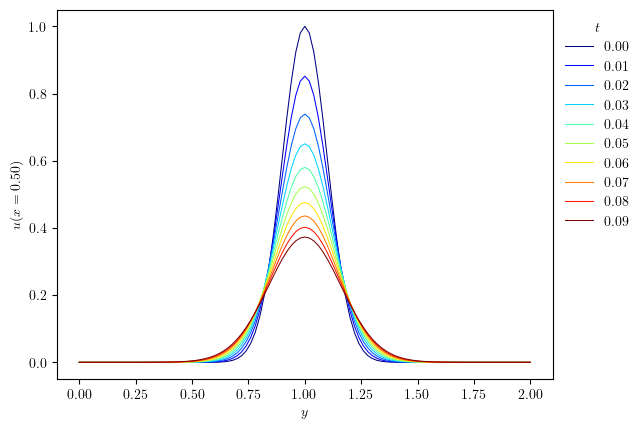

In [7]:
slc = slice(0, None)
x_lines, y_lines = [], []

for ui in u.series[slc]:
    x_axis, x_line, y_value = cross_section(ui, 'x', 0.5)
    x_lines.append((x_axis, x_line))
    y_axis, y_line, x_value = cross_section(ui, 'y', 0.5)
    y_lines.append((y_axis, y_line))

legend_labels = [f'{time:.2f}' for time in u.time_series[slc]]
plot_line(x_lines, legend_labels, 't', cycler='jet', x_label='x', y_label=f'{u.name}(y={y_value:.2f})')
plot_line(y_lines, legend_labels, 't', cycler='jet', x_label='y', y_label=f'{u.name}(x={x_value:.2f})')

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '$u(t=0.09)$'}, xlabel='$x$', ylabel='$y$'>)

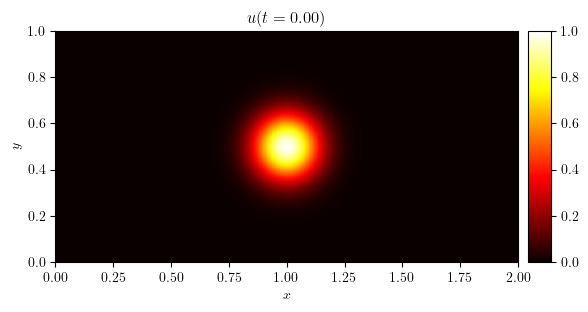

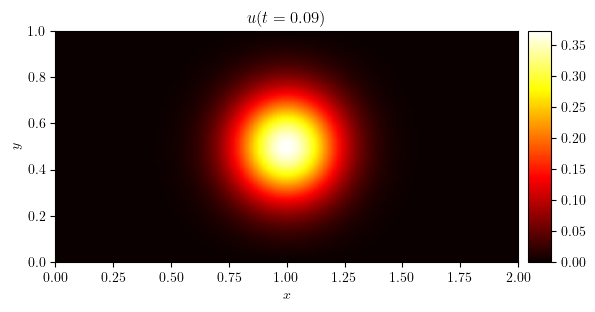

In [8]:
plot_colormap(u.series[0], title=f'{u.name}(t={u.time_series[0]:.2f})')
plot_colormap(u.series[-1], title=f'{u.name}(t={u.time_series[-1]:.2f})')